# Introduction
When working on my kernel, I have spent some time on preprocessing and augmentation, and encountered some problems. Cropping, preprocessing and augmentation can be quite computationally expensive (even to the extent images are not loaded quickly enough to keep the GPU running at full speed). Furthermore, default ImageDataGenerators couldn't crop or preprocess the images in exactly the way and order I wanted.

To speed things up, I show a few tricks here. This hopefully allows you to train your neural nets for more epochs or pre-train on (much more!) data from the previous challenge. Note that most of the methods presented here, are copied from [this excellent kernel](https://www.kaggle.com/ratthachat/aptos-updated-preprocessing-ben-s-cropping) (recommended read), which in turn is based on the preprocessing method of [Ben Graham](https://github.com/btgraham/SparseConvNet/tree/kaggle_Diabetic_Retinopathy_competition) used in the previous challenge.

I am new to Kaggle, and this is the first kernel I share, so please be a bit gentle in your feedback.

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
IMAGE_SIZE = 224

# Code

In [2]:
def info_image(im):
    # Compute the center (cx, cy) and radius of the eye
    cy = im.shape[0]//2
    midline = im[cy,:]
    midline = np.where(midline>midline.mean()/3)[0]
    if len(midline)>im.shape[1]//2:
        x_start, x_end = np.min(midline), np.max(midline)
    else: # This actually rarely happens p~1/10000
        x_start, x_end = im.shape[1]//10, 9*im.shape[1]//10
    cx = (x_start + x_end)/2
    r = (x_end - x_start)/2
    return cx, cy, r

def resize_image(im, augmentation=True):
    # Crops, resizes and potentially augments the image to IMAGE_SIZE
    cx, cy, r = info_image(im)
    scaling = IMAGE_SIZE/(2*r)
    rotation = 0
    if augmentation:
        scaling *= 1 + 0.3 * (np.random.rand()-0.5)
        rotation = 360 * np.random.rand()
    M = cv2.getRotationMatrix2D((cx,cy), rotation, scaling)
    M[0,2] -= cx - IMAGE_SIZE/2
    M[1,2] -= cy - IMAGE_SIZE/2
    return cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE)) # This is the most important line

def subtract_median_bg_image(im):
    k = np.max(im.shape)//20*2+1
    bg = cv2.medianBlur(im, k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def subtract_gaussian_bg_image(im):
    k = np.max(im.shape)/10
    bg = cv2.GaussianBlur(im ,(0,0) ,k)
    return cv2.addWeighted (im, 4, bg, -4, 128)

def id_to_image(id_code, resize=True, augmentation=False, subtract_gaussian=False, subtract_median=False):
    path = '../input/train_images/{}.png'.format(id_code)
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    if resize_image:
        im = resize_image(im, augmentation)
    if subtract_gaussian:
        im = subtract_gaussian_bg_image(im)
    if subtract_median:
        im = subtract_median_bg_image(im)
    return im

The main trick for speed-up the line *cv2.warpAffine(im,M,(IMAGE_SIZE,IMAGE_SIZE))*. This effectively does cropping, resizing, scaling and rotation in a single affine transformation. I got a speedup of at least a factor 2 (and probably more), compared to doing those operations one-by-one. Another advantage of combining resizing and augmentation into a single operation is that you do not have to interpolate the image multiple times, which typically degrades image quality.

# Sample images

CPU times: user 4.66 s, sys: 380 ms, total: 5.04 s
Wall time: 4.26 s


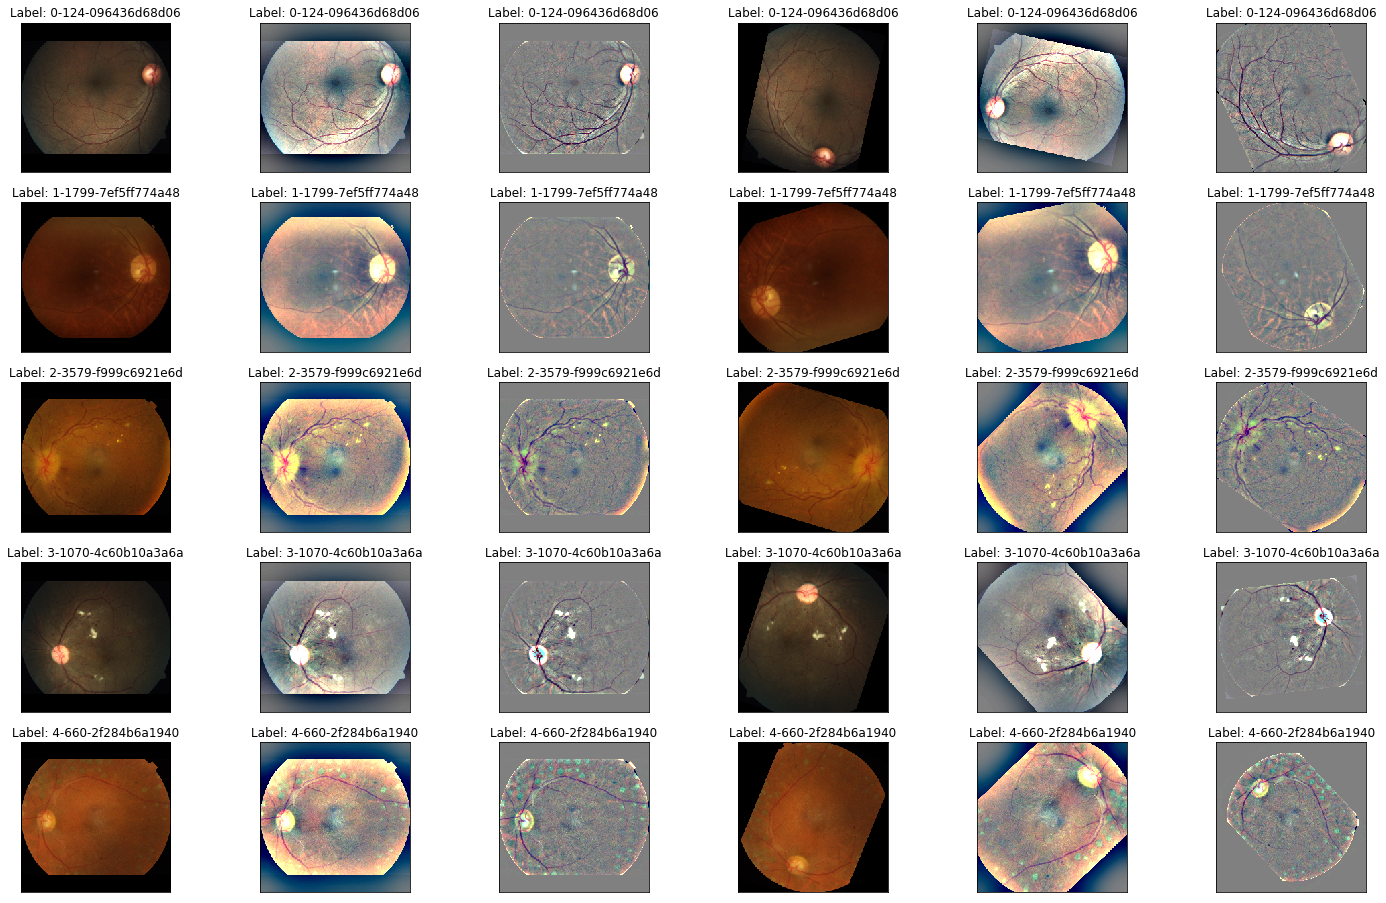

In [3]:
%%time
df_train = pd.read_csv('../input/train.csv')
fig = plt.figure(figsize=(25, 16))
SEED = np.random.randint(0,100)

def plot_col(col, id2im, n_cols=6):
    for class_id in range(0,5):
        for i, (idx, row) in enumerate(df_train.loc[df_train['diagnosis'] == class_id].sample(1, random_state=SEED).iterrows()):
            ax = fig.add_subplot(5, n_cols, class_id * n_cols + i + col, xticks=[], yticks=[])
            im = id2im(row['id_code'])
            plt.imshow(im)
            ax.set_title('Label: %d-%d-%s' % (class_id, idx, row['id_code']) )

# display normal image of each class
plot_col(1, lambda x: id_to_image(x))

# display normal image of each class
plot_col(4, lambda x: id_to_image(x, augmentation=True))

# display normal image of each class
plot_col(2, lambda x: id_to_image(x, subtract_gaussian=True))

# display normal image of each class
plot_col(5, lambda x: id_to_image(x, subtract_gaussian=True, augmentation=True))

# display normal image of each class
plot_col(3, lambda x: id_to_image(x, subtract_median=True))

# display normal image of each class
plot_col(6, lambda x: id_to_image(x, subtract_median=True, augmentation=True))

The first column shows the normal images, the second columns shows the images processed with an approach similar to Ben Graham's approach.

The third column shows the images when a Median filter is used (instead of a Gaussian filter). A median filter is very effective in seperating small or narrow objects from a relatively continous background. As a result, the blood vessels and small objects are much more apparant in the third column compared to the first two. That may be useful (or not!). It is also relatively succesful in removing color from the image, which may make images shot with different cameras more comparable (or removes potentially usefull information!). Put it in the comments if you get better/worse results with the Median filter.

The last three columns just show random rotations/scalings. You can use the code to implement your own ImageGenerator and generate augmented images on the fly.

Ok, thanks. that's it. Happy training!